# Generative Adversarial Networks
### Deep Convolutional Generative Adversarial Network (DCGAN) 
### Example 2

### Preparation 
**Step 1.** Download and install Git
https://git-scm.com/download/win
    
**Step 2:** Install the following libraries 
- To generate GIFs
- pip install imageio
- pip install git+https://github.com/tensorflow/docs

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.15.0'

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset
You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [5]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [6]:
print(len(train_labels))

60000


In [7]:
train_images.shape

(60000, 28, 28)

In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
train_images.shape

(60000, 28, 28, 1)

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

This code is using TensorFlow's Dataset API to create a dataset for training a machine learning model. Let's break down the code step by step:

- tf.data.Dataset.from_tensor_slices(train_images): This part of the code creates a TensorFlow dataset from a given NumPy array or tensor (train_images). Each element of the dataset will correspond to a slice of the first dimension of train_images. So, if train_images is a NumPy array with dimensions [num_samples, ...], where num_samples is the number of samples in the dataset, then each element of the dataset will be one sample.

- shuffle(BUFFER_SIZE): This part shuffles the elements of the dataset. It takes an argument BUFFER_SIZE, which specifies the size of the buffer used for shuffling. TensorFlow will maintain a buffer of this size and randomly sample elements from it to shuffle the dataset. This helps in randomizing the order of the data during training, which can be beneficial for stochastic gradient descent.

- batch(BATCH_SIZE): This part batches together consecutive elements of the dataset into batches of size BATCH_SIZE. Batching is important for training neural networks because it allows you to process multiple data points simultaneously, which can improve training efficiency, especially when using hardware accelerators like GPUs or TPUs. BATCH_SIZE specifies the number of elements to include in each batch.

Putting it all together, the train_dataset created by this code will contain shuffled batches of training data, where each batch contains BATCH_SIZE samples, and the order of samples within each batch is randomized. This dataset can then be used to train a machine learning model, typically in a training loop where you iterate over batches of data and update the model parameters accordingly.

### Create the models
Both the generator and discriminator are defined using the Keras Sequential API.

The Keras Sequential API is a high-level neural networks API provided by TensorFlow. It allows you to define models for deep learning tasks using a simple, linear stack of layers. This API is user-friendly, making it ideal for beginners and for quickly prototyping deep learning models. Here's an overview of how the Sequential API works:

- Initialization: You start by creating a Sequential model object.

- Layer Stacking: You then add layers to the model one by one. These layers can be dense (fully connected), convolutional, recurrent, or any other type of layer provided by Keras.

- Compilation: After defining the architecture of the model by stacking layers, you compile the model. During compilation, you specify important parameters such as the loss function, the optimizer, and the metrics to monitor during training.

#### The Generator
The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    # Layer 1: 
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    # Layer 2: 
    model.add(layers.BatchNormalization())
    # Layer 3: 
    model.add(layers.LeakyReLU())
    
    # Layer 4: 
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    
    # Layer 5: error
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    # Layer 6: 
    model.add(layers.BatchNormalization())
    # Layer 7: 
    model.add(layers.LeakyReLU())

    # Layer 8: error
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    # Layer 9: 
    model.add(layers.BatchNormalization())
    # Layer 10: 
    model.add(layers.LeakyReLU())
    # Layer 11: 
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

let's break down the code make_generator_model() line by line:

- def make_generator_model():: This line defines a Python function named make_generator_model. This function is intended to create a generator model for a Generative Adversarial Network (GAN) using TensorFlow/Keras.

- model = tf.keras.Sequential(): This line initializes a sequential model using Keras. Sequential models are linear stacks of layers.

- model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))): This line adds a dense (fully connected) layer to the model. The layer has $7\times7\times256 = 12544$ units, meaning it has $12544$ neurons. The input_shape=(100,) specifies that the input to this layer is a 1D tensor of shape (100,). The use_bias=False argument indicates that the layer will not include bias terms.

- model.add(layers.BatchNormalization()): This line adds a batch normalization layer to the model. Batch normalization is a technique used to improve the training speed and stability of deep neural networks by normalizing the inputs of each layer.

- model.add(layers.LeakyReLU()): This line adds a Leaky ReLU activation function to the model. Leaky ReLU is similar to the traditional ReLU activation function but allows a small, positive gradient when the input is negative, which can help mitigate the vanishing gradient problem.

- model.add(layers.Reshape((7, 7, 256))): This line adds a reshape layer to the model. It reshapes the output of the previous layer to have a shape of (7, 7, 256).

- assert model.output_shape == (None, 7, 7, 256): This line ensures that the output shape of the model matches the expected shape (None, 7, 7, 256). The None dimension indicates that the batch size can be variable.

The next three blocks of code (model.add(layers.Conv2DTranspose(...)), model.add(layers.BatchNormalization()), model.add(layers.LeakyReLU())) repeat similar operations but with different parameters. These lines add convolutional transpose layers (also known as deconvolutional layers), batch normalization layers, and Leaky ReLU activation functions sequentially to the model.<br>

This line adds a transposed convolutional layer (Conv2DTranspose) to the model. Transposed convolutional layers are used for upsampling or generating higher-resolution outputs from lower-resolution inputs.<br>
**Parameters:**
- 128: This indicates the number of filters (or channels) in the layer. The layer will output 128 feature maps.
- (5, 5): This specifies the kernel size (filter size) of the convolution operation. In this case, it's a 5x5 filter.
- strides=(1, 1): The stride of the convolution operation. Here, it's (1, 1), which means the convolution operation moves 1 pixel at a time in both the height and width dimensions.
- padding='same': This ensures that the output has the same spatial dimensions as the input by padding the input if necessary.
- use_bias=False: This indicates that the layer will not use bias terms. Overall, this layer performs a transposed convolution operation, which effectively upsamples the input to the desired output shape.
- The final block of code (model.add(layers.Conv2DTranspose(...))) adds a convolutional transpose layer with a tanh activation function. This layer is responsible for generating the output of the generator model. The tanh activation function ensures that the output values are scaled to the range [-1, 1], suitable for representing images.<br>

assert model.output_shape == (None, 28, 28, 1): This line ensures that the output shape of the model matches the expected shape (None, 28, 28, 1), which corresponds to the shape of the generated images.
return model: Finally, the function returns the completed generator model.

Use the (as yet untrained) generator to create an image.

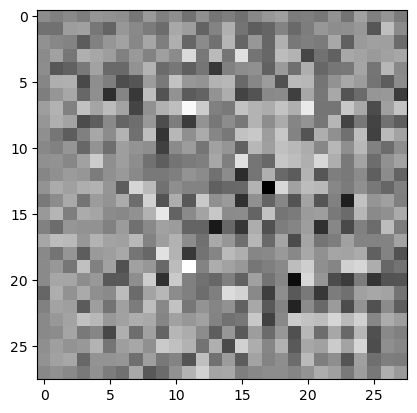

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

This code appears to be generating an image using a pre-trained generator model. Let's break it down step by step:

- generator = make_generator_model(): This line likely calls a function make_generator_model() that creates and returns a generator model. This generator model is typically a neural network, possibly implemented using a deep learning framework like TensorFlow.

- noise = tf.random.normal([1, 100]): This line generates random noise with shape [1, 100]. The noise is typically sampled from a normal distribution using TensorFlow's random module (tf.random.normal). In many generative models, such as Generative Adversarial Networks (GANs), this noise serves as input to the generator network to produce synthetic images.

- generated_image = generator(noise, training=False): Here, the generator model is called with the generated noise as input. The training=False argument indicates that the model should run in inference mode rather than training mode. This means that any layers that behave differently during training, such as dropout or batch normalization layers, will operate in inference mode.

- plt.imshow(generated_image[0, :, :, 0], cmap='gray'): Finally, this line displays the generated image using Matplotlib's imshow function. Since generated_image likely has a shape of [1, height, width, channels], this line extracts the first (and only) image from the batch and selects its first channel (assuming it's a grayscale image) for display. The cmap='gray' argument specifies that the colormap used for displaying the image should be grayscale.

#### The Discriminator
The discriminator is a CNN-based image classifier.

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # Layer 1
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    # Layer 2
    model.add(layers.LeakyReLU())
    # Layer 3
    model.add(layers.Dropout(0.3))
    # Layer 4
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # Layer 5
    model.add(layers.LeakyReLU())
    # Layer 6
    model.add(layers.Dropout(0.3))
    # Layer 7
    model.add(layers.Flatten())
    # Layer 8
    model.add(layers.Dense(1))

    return model

This code defines a discriminator model, typically used in adversarial learning setups like Generative Adversarial Networks (GANs). Let's go through it step by step:

- model = tf.keras.Sequential(): This line initializes a sequential model using TensorFlow's Keras API. A sequential model is a linear stack of layers.

- model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1])): This line adds a convolutional layer to the model. It has 64 filters, each with a kernel size of (5, 5), a stride of (2, 2) (meaning the filter is applied every 2 pixels), and 'same' padding, which means the spatial dimensions of the output feature map are the same as the input. The input_shape specifies the shape of the input data, which is a 28x28 grayscale image ([28, 28, 1]).

- model.add(layers.LeakyReLU()): This adds a Leaky ReLU activation function to introduce non-linearity. Leaky ReLU is similar to the traditional ReLU but allows a small, positive gradient when the input is negative, helping to alleviate the vanishing gradient problem.

- model.add(layers.Dropout(0.3)): Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of input units to zero during training. Here, it's applied with a dropout rate of 0.3, meaning 30% of the units will be randomly set to zero during training.

- model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')): Similar to step 2, this adds another convolutional layer with 128 filters and the same configuration as before.

- model.add(layers.LeakyReLU()) and model.add(layers.Dropout(0.3)): Again, these lines add Leaky ReLU activation and dropout layers, applying the same configuration as described above.

- model.add(layers.Flatten()): This layer flattens the output from the convolutional layers into a 1D tensor. This is necessary to connect the convolutional layers to a fully connected (Dense) layer.

- model.add(layers.Dense(1)): Finally, a dense layer with a single neuron is added. This neuron will output a single value, representing the discriminator's prediction of whether the input image is real or fake.

- return model: The function returns the compiled discriminator model.

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00201605]], shape=(1, 1), dtype=float32)


### Define the loss and optimizers
Define loss functions and optimizers for both models.

In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### Discriminator loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Define the training loop

In [17]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

- EPOCHS = 50: This line sets the number of epochs for training. An epoch refers to one complete pass through the entire dataset during training.

- noise_dim = 100: This line sets the dimensionality of the noise vector. In many generative models like Generative Adversarial Networks (GANs), noise vectors are input to the generator model to produce new samples. Here, noise_dim is set to 100, meaning each noise vector will have 100 dimensions.

- num_examples_to_generate = 16: This line sets the number of examples to generate. In this context, it likely means the number of images to generate at once for visualization or evaluation purposes.

- seed = tf.random.normal([num_examples_to_generate, noise_dim]):

This line generates a random seed or noise tensor using TensorFlow's random normal distribution.
The shape of the tensor is specified as [num_examples_to_generate, noise_dim], meaning there will be num_examples_to_generate noise vectors, each with noise_dim dimensions. This seed is often used as input to the generator model to produce a batch of generated samples. It's useful for visualizing progress during training or generating new samples after training is complete.

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

The above code defines a TensorFlow function train_step decorated with @tf.function. Let's break it down:
- @tf.function: This decorator converts the Python function train_step into a TensorFlow graph function. TensorFlow graph functions are compiled into a graph representation, which can lead to faster execution compared to the original Python code.

- def train_step(images):: This line defines the function train_step, which takes a batch of images (images) as input. This function performs one step of training in a GAN (Generative Adversarial Network).

- noise = tf.random.normal([BATCH_SIZE, noise_dim]): It generates a batch of random noise vectors of shape [BATCH_SIZE, noise_dim]. BATCH_SIZE = 256 and noise_dim = 100 are defined elsewhere in the code.

- with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:: This code block sets up two gradient tapes, one for the generator (gen_tape) and one for the discriminator (disc_tape). Gradient tapes are used to compute gradients with respect to the trainable variables.

- generated_images = generator(noise, training=True): This line generates fake images by passing the random noise through the generator model (generator). The training=True argument ensures that the model is in training mode, which can be important for models that include layers like batch normalization or dropout.

- real_output = discriminator(images, training=True): This line computes the output of the discriminator (discriminator) on real images (images). Again, training=True ensures that the discriminator is in training mode.

- fake_output = discriminator(generated_images, training=True): This line computes the output of the discriminator on the generated (fake) images.

- gen_loss = generator_loss(fake_output): This line computes the loss for the generator based on the output of the discriminator on the generated images. generator_loss is a function that computes the loss for the generator.

- disc_loss = discriminator_loss(real_output, fake_output): This line computes the loss for the discriminator based on its outputs for real and fake images. discriminator_loss is a function that computes the loss for the discriminator.

- Gradient computation: The next lines compute the gradients of the generator and discriminator losses with respect to their trainable variables using the gradient tapes.

- generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)): This line applies the computed gradients to the generator's trainable variables using an optimizer (generator_optimizer). Similarly, the gradients for the discriminator are applied to its trainable variables.

In summary, this train_step function is an essential part of training a G

In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

This code defines a training loop for training the above GAN, over a specified number of epochs. Let's break down the code:

- def train(dataset, epochs):: This function train takes two arguments: dataset, which likely contains the training data, and epochs, which specifies the number of training epochs.

- for epoch in range(epochs):: This loop iterates over each epoch from 0 to epochs - 1.

- start = time.time(): This line records the start time of each epoch, used for measuring the time taken for each epoch.

- for image_batch in dataset:: This loop iterates over batches of images in the dataset. It's assumed that dataset is an iterable containing batches of images.

- train_step(image_batch): This line calls a function train_step, which performs one step of training using the given batch of images. The details of this function are not provided here but typically involve updating the weights of the generator and discriminator networks of a GAN.

- display.clear_output(wait=True): This line clears the output display, likely used to show progress updates during training.

- generate_and_save_images(generator, epoch + 1, seed): This line calls a function generate_and_save_images, which generates and saves images using the generator model. It's likely used to visualize the progress of the generator over training epochs.

- if (epoch + 1) % 15 == 0:: This condition checks if the current epoch number is a multiple of 15. If it is, it saves the model's current state using a checkpoint.

- checkpoint.save(file_prefix = checkpoint_prefix): This line saves the model checkpoint using the provided checkpoint prefix.

- print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start)): This line prints the time taken for the current epoch.

The training loop concludes by generating and saving images using the generator after the final epoch.

Generate and save images

In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('./results/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Train the model
Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

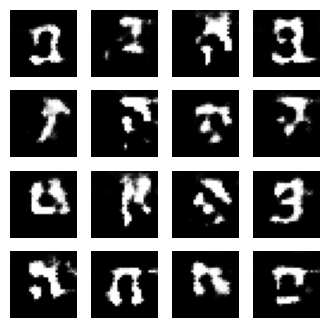

Time for epoch 11 is 158.52828907966614 sec


In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Create a GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('./results/image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use imageio to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Next steps
This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset available on Kaggle. To learn more about GANs see the NIPS 2016 Tutorial: Generative Adversarial Networks.